In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.setup import data_setup
from gallifrey.utilities.math import calculate_pca
from gallifrey.utilities.dataframe import aggregated_dataframe, rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    ridgeplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 4096
sim_id = "09_18"

In [5]:
ds, mw, stellar_model, imf, planet_model = data_setup(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-09-12 14:41:01,778 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-09-12 14:41:01,836 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-09-12 14:41:01,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-09-12 14:41:01,837 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-09-12 14:41:01,837 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-09-12 14:41:01,838 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-12 14:41:01,839 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-09-12 14:41:01,839 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-09-12 14:41:01,839 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-09-12 14:41:01,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

## PLOT SETUP

In [6]:
set_plot_defaults()
figure_directory = "Galaxy_components"

## CREATE DATA SOURCE

In [7]:
radius = 0.1 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

In [8]:
components = ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"]
data = aggregated_dataframe(
    components,
    [
        "[Fe/H]",
        "stellar_age",
        "Masses",
    ],
    data_source=sphere_data,
    type_name="Component",
    custom_units={"stellar_age": "Gyr"},
)

# rename components
data["Component"] = data["Component"].apply(
    lambda type: type.replace("_", " ").replace(" stars", "").title()
    if type.endswith("_stars")
    else type
)

# filtering values
filters = {"[Fe/H]": (-2.5, 1)}
for field_value, ranges in filters.items():
    data = data[data[field_value].between(*ranges)]

# rename labels
data, labels = rename_labels(data)

## FRACTION OF MASS IN COMPONENTS

In [9]:
data.groupby("Component")["Masses"].sum()

Component
Bulge         9.913674e+09
Halo          3.571685e+09
Thick Disk    1.969320e+10
Thin Disk     2.886859e+10
Name: Masses, dtype: float64

In [10]:
data.groupby("Component")["Masses"].sum() / data["Masses"].sum()

Component
Bulge         0.159776
Halo          0.057564
Thick Disk    0.317391
Thin Disk     0.465269
Name: Masses, dtype: float64

## STELLAR AGE IN COMPONENTS

In [11]:
data.groupby("Component")[labels["stellar_age"]].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,56214.000000,19661.000000,107483.000000,145841.000000
mean,8.255047,8.046465,5.625049,2.861234
std,2.889941,2.390179,2.925887,2.270287
min,0.021125,0.046393,0.020130,0.020130
25%,6.791078,6.127977,3.582193,1.137269
50%,8.722919,7.892196,5.607274,2.414024
75%,10.239305,9.913492,7.573165,3.870247
max,13.462528,13.409409,13.452168,13.457962


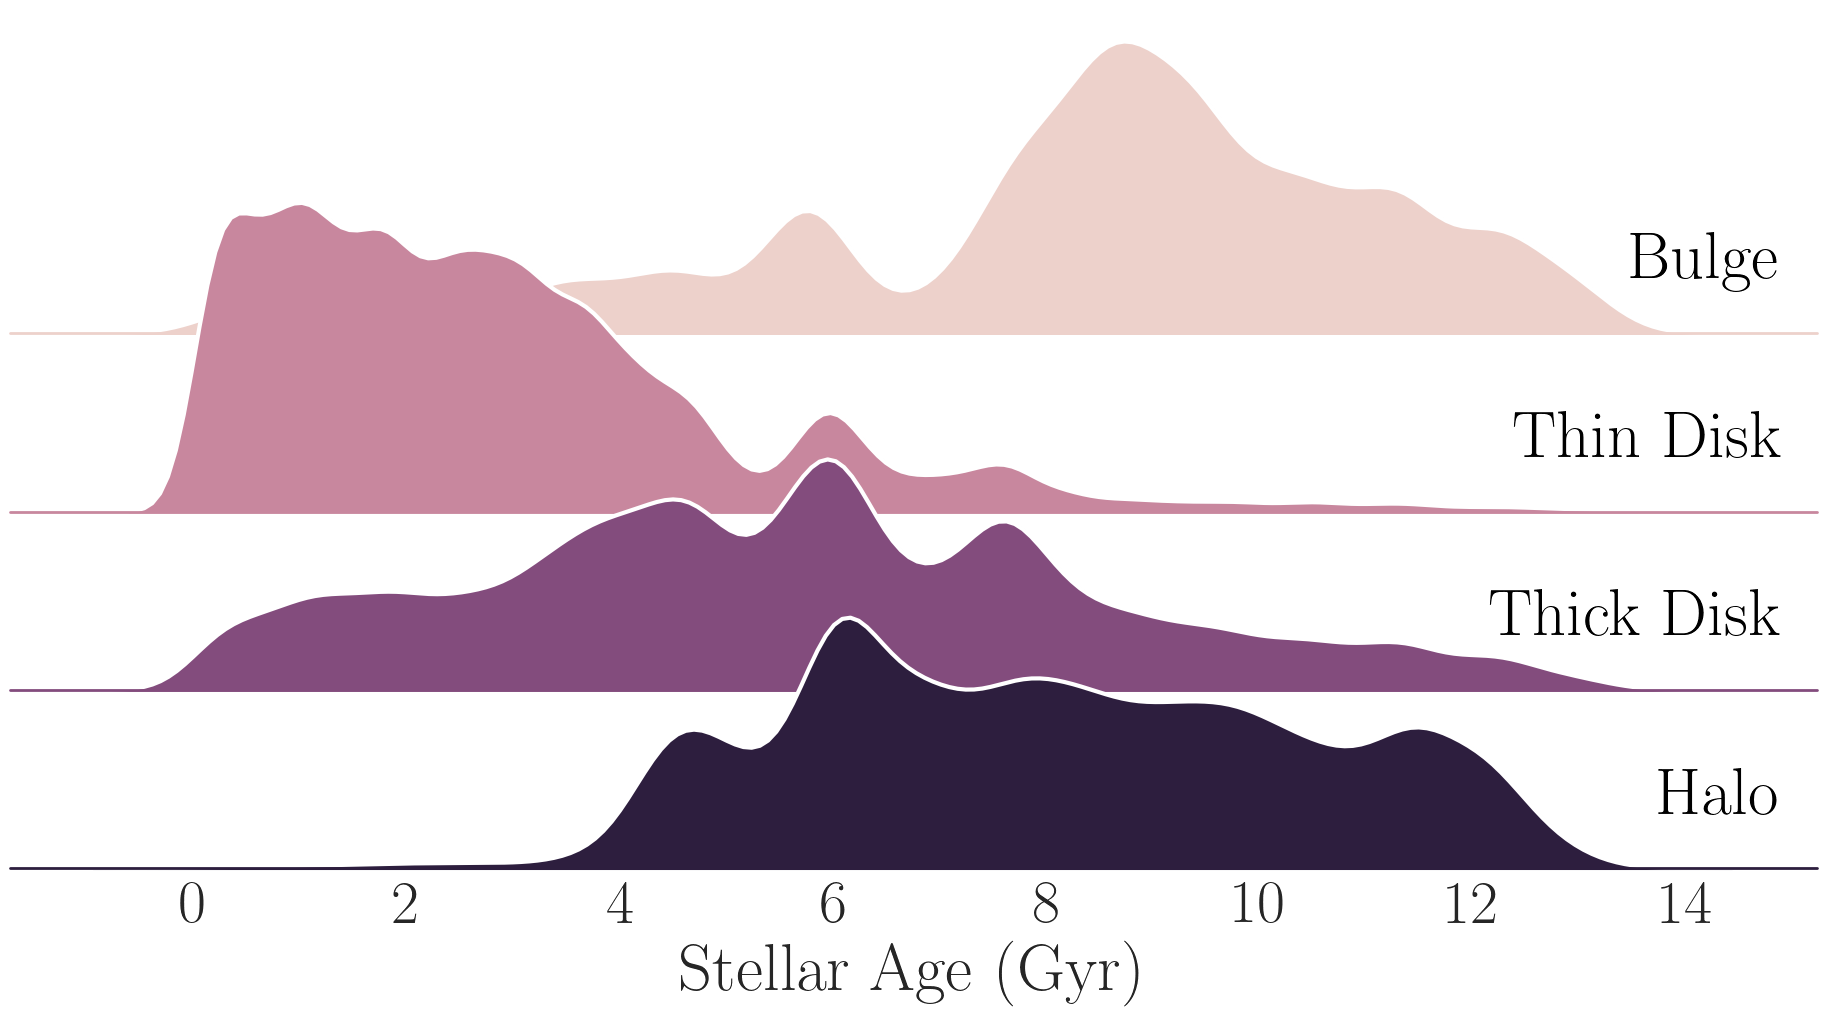

In [12]:
ridgeplot_age = ridgeplot(
    data,
    x=labels["stellar_age"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.98, 0.22],
)
FigureProcessor(ridgeplot_age.figure).save(
    "ridgeplot_age.pdf", sub_directory=figure_directory
)

## METALLICITY IN COMPONENTS

In [13]:
data.groupby("Component")["[Fe/H]"].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,56214.000000,19661.000000,107483.000000,145841.000000
mean,-0.200956,-0.537097,-0.121561,0.029994
std,0.429620,0.463434,0.404813,0.279671
min,-2.495653,-2.497246,-2.488860,-2.475818
25%,-0.491378,-0.764005,-0.368017,-0.154355
50%,-0.166446,-0.490950,-0.122497,0.040846
75%,0.106645,-0.226882,0.191659,0.237340
max,0.716523,0.840895,0.719918,0.718245


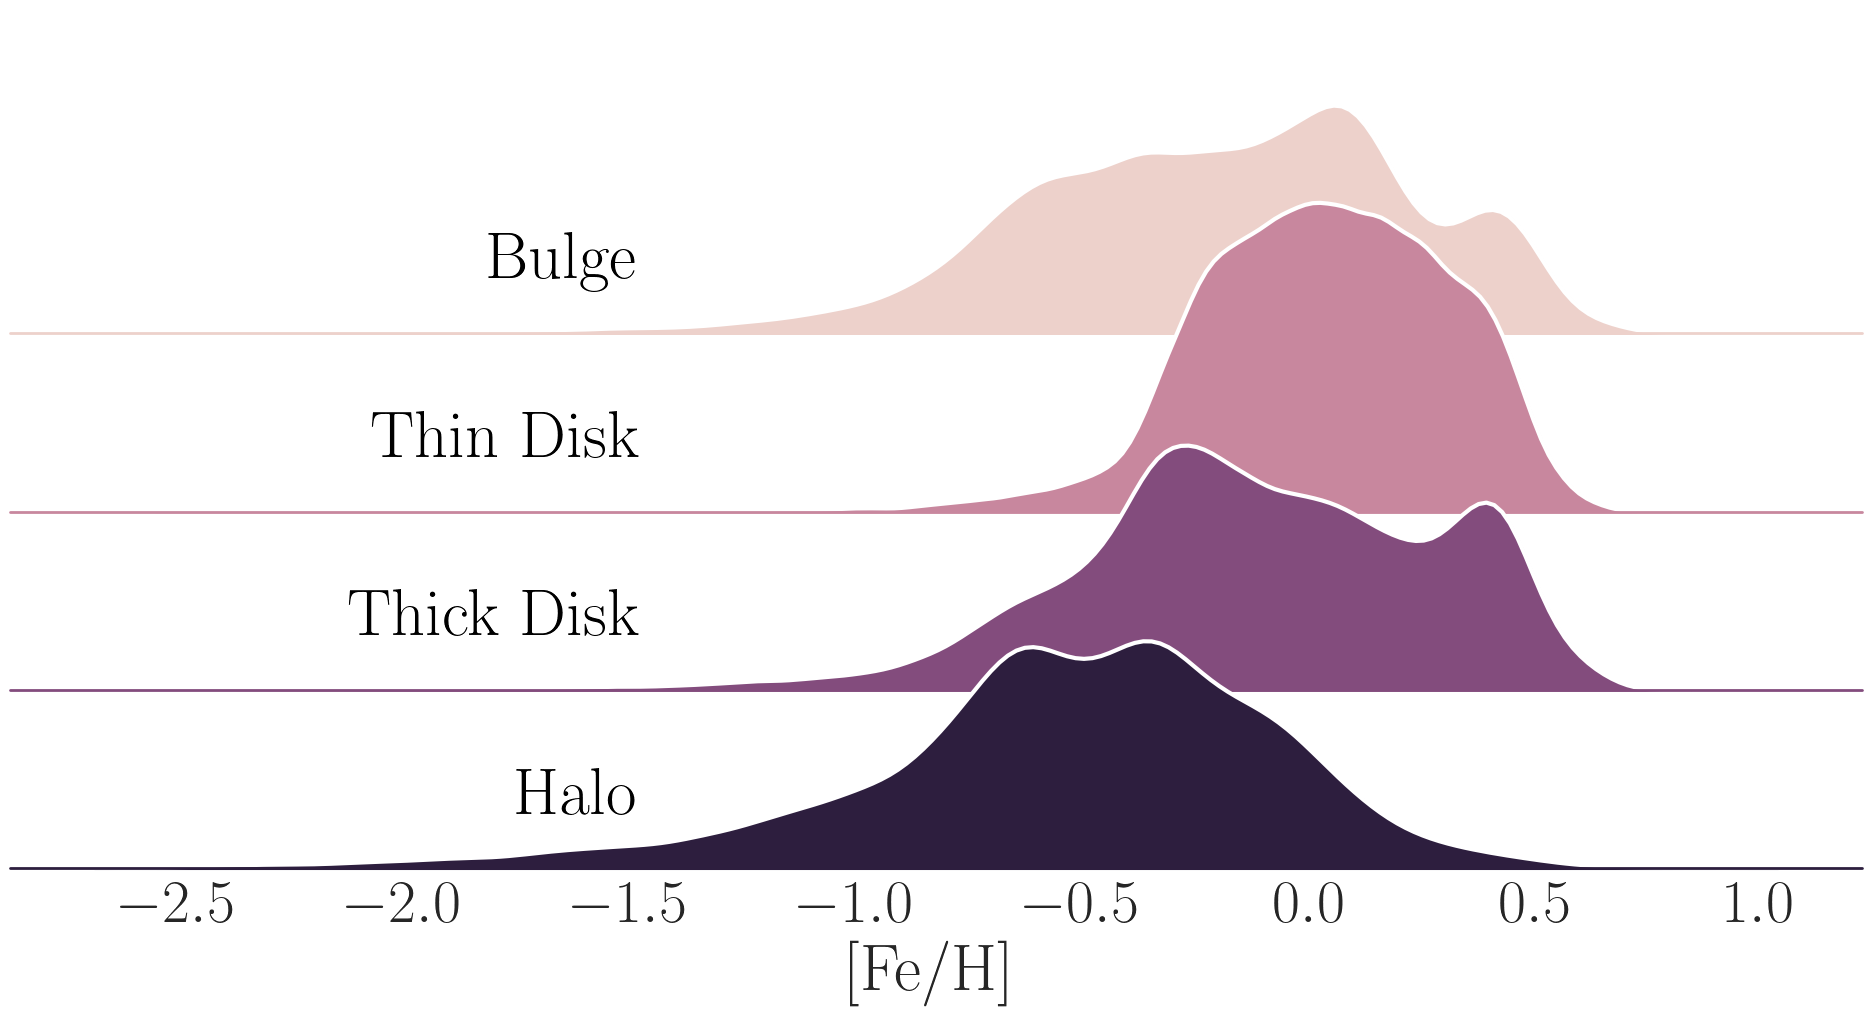

In [14]:
ridgeplot_metallicity = ridgeplot(
    data,
    x=labels["[Fe/H]"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.34, 0.22],
)
FigureProcessor(ridgeplot_metallicity.figure).save(
    "ridgeplot_metallicity.pdf", sub_directory=figure_directory
)

## PRICIPAL COMPONENTS

In [15]:
variance_ratios = pd.DataFrame(
    np.array(
        [
            calculate_pca(
                sphere_data[component, "particle_position"].to("kpc")
            ).explained_variance_ratio_
            for component in components
        ]
    ).T,
    columns=components,
).T
variance_ratios

,0,1,2
bulge_stars,0.382565,0.336808,0.280627
thin_disk_stars,0.532835,0.453933,0.013232
thick_disk_stars,0.469200,0.418999,0.111800
halo_stars,0.407759,0.358262,0.233979
